# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Оглавление

1. Изучение данных из файла
2. Предобработка данных
3. Расчёты и добавление результатов в таблицу
4. Исследовательский анализ данных
5. Общий вывод

## 1. Изучение данных из файла 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
estate_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(estate_data.head())
estate_data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Вывод

В таблице 22 колонок, типы данных - float64, int64, object, bool

Некоторые столбцы названы не по змеиному регистру.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

Согласно документации к данным:

* `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
* `balcony` — число балконов
* `ceiling_height` — высота потолков (м)
* `cityCenters_nearest` — расстояние до центра города (м)
* `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
* `first_day_exposition` — дата публикации
* `floor` — этаж
* `floors_total` — всего этажей в доме
* `is_apartment` — апартаменты (булев тип)
* `kitchen_area` — площадь кухни в квадратных метрах (м²)
* `last_price` — цена на момент снятия с публикации
* `living_area` — жилая площадь в квадратных метрах (м²)
* `locality_name` — название населённого пункта
* `open_plan` — свободная планировка (булев тип)
* `parks_around3000` — число парков в радиусе 3 км
* `parks_nearest` — расстояние до ближайшего парка (м)
* `ponds_around3000` — число водоёмов в радиусе 3 км
* `ponds_nearest` — расстояние до ближайшего водоёма (м)
* `rooms` — число комнат
* `studio` — квартира-студия (булев тип)
* `total_area` — площадь квартиры в квадратных метрах (м²)
* `total_images` — число фотографий квартиры в объявлении

## 2. Предобработка данных 

In [2]:
# Исправил названия столбцов, согласно змеиному регистру
estate_data.rename(
    columns = {'cityCenters_nearest' : 'city_centers_nearest', 
    'parks_around3000' : 'parks_around_3000', 
    'ponds_around3000' : 'ponds_around_3000'}, inplace = True)
print(estate_data.columns)

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


In [3]:
# Подсчет пропусков до предобработки
print(estate_data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [4]:
# Удалил строчки с пропущенными значениями в названии населённого пункта и сменил индексы
print('Пропуски до (в столбце locality_name):', estate_data['locality_name'].isna().sum())
estate_data.dropna(subset = ['locality_name'], inplace = True)
estate_data = estate_data.reset_index(drop = True)
print('Пропуски после (в столбце locality_name):', estate_data['locality_name'].isna().sum())

Пропуски до (в столбце locality_name): 49
Пропуски после (в столбце locality_name): 0


In [5]:
# Заменяю Nan на 0
print('Пропуски до (в столбце balcony):', estate_data['balcony'].isna().sum())
estate_data['balcony'] = estate_data['balcony'].fillna(0)
print('Пропуски после (в столбце balcony):', estate_data['balcony'].isna().sum())

Пропуски до (в столбце balcony): 11513
Пропуски после (в столбце balcony): 0


In [6]:
# Заменяю Nan на False
print('Пропуски до (в столбце is_apartment):', estate_data['is_apartment'].isna().sum())
estate_data['is_apartment'] = estate_data['is_apartment'].fillna(False)
print('Пропуски после (в столбце is_apartment):', estate_data['is_apartment'].isna().sum())

Пропуски до (в столбце is_apartment): 20890
Пропуски после (в столбце is_apartment): 0


In [7]:
# Заменяю Nan на 0
print('Пропуски до (в столбце parks_around_3000):', estate_data['parks_around_3000'].isna().sum())
estate_data['parks_around_3000'] = estate_data['parks_around_3000'].fillna(0)
print('Пропуски после (в столбце parks_around_3000):', estate_data['parks_around_3000'].isna().sum())

Пропуски до (в столбце parks_around_3000): 5510
Пропуски после (в столбце parks_around_3000): 0


In [8]:
# Заменяю Nan на 3500
print('Пропуски до (в столбце parks_nearest):', estate_data['parks_nearest'].isna().sum())
estate_data['parks_nearest'] = estate_data['parks_nearest'].fillna(3500)
print('Пропуски после (в столбце parks_nearest):', estate_data['parks_nearest'].isna().sum())

Пропуски до (в столбце parks_nearest): 15586
Пропуски после (в столбце parks_nearest): 0


In [9]:
# Заменяю Nan на 0
print('Пропуски до (в столбце ponds_around_3000):', estate_data['ponds_around_3000'].isna().sum())
estate_data['ponds_around_3000'] = estate_data['ponds_around_3000'].fillna(0)
print('Пропуски после (в столбце ponds_around_3000):', estate_data['ponds_around_3000'].isna().sum())

Пропуски до (в столбце ponds_around_3000): 5510
Пропуски после (в столбце ponds_around_3000): 0


In [10]:
# Заменяю Nan на 3500
print('Пропуски до (в столбце ponds_nearest):', estate_data['ponds_nearest'].isna().sum())
estate_data['ponds_nearest'] = estate_data['ponds_nearest'].fillna(3500)
print('Пропуски после (в столбце ponds_nearest):', estate_data['ponds_nearest'].isna().sum())

Пропуски до (в столбце ponds_nearest): 14565
Пропуски после (в столбце ponds_nearest): 0


In [11]:
# Заменяю пропуски в столбце на медианное значение
print('Пропуски до (в столбце airports_nearest):', estate_data['airports_nearest'].isna().sum())
estate_data.loc[estate_data['airports_nearest'].isna(), 'airports_nearest'] = estate_data['airports_nearest'].median()
print('Пропуски после (в столбце airports_nearest):', estate_data['airports_nearest'].isna().sum())

Пропуски до (в столбце airports_nearest): 5534
Пропуски после (в столбце airports_nearest): 0


In [12]:
# Заменяю пропуски в столбце на медианное значение
print('Пропуски до (в столбце city_centers_nearest):', estate_data['city_centers_nearest'].isna().sum())
estate_data.loc[estate_data['city_centers_nearest'].isna(), 'city_centers_nearest'] = estate_data['city_centers_nearest'].median()
print('Пропуски после (в столбце city_centers_nearest):', estate_data['city_centers_nearest'].isna().sum())

Пропуски до (в столбце city_centers_nearest): 5511
Пропуски после (в столбце city_centers_nearest): 0


In [13]:
# Заменяю пропуски в столбце на медианное значение
print('Пропуски до (в столбце ceiling_height):', estate_data['ceiling_height'].isna().sum())
estate_data.loc[estate_data['ceiling_height'].isna(), 'ceiling_height'] = estate_data['ceiling_height'].median()
print('Пропуски после (в столбце ceiling_height):', estate_data['ceiling_height'].isna().sum())

Пропуски до (в столбце ceiling_height): 9160
Пропуски после (в столбце ceiling_height): 0


In [14]:
# Заменяю пропуски в столбце на медианное значение
print('Пропуски до (в столбце floors_total):', estate_data['floors_total'].isna().sum())
estate_data.loc[estate_data['floors_total'].isna(), 'floors_total'] = estate_data['floors_total'].median()
print('Пропуски после (в столбце floors_total):', estate_data['floors_total'].isna().sum())

Пропуски до (в столбце floors_total): 85
Пропуски после (в столбце floors_total): 0


In [15]:
# Заменяю пропуски в столбце на медианное значение через цикл
print('Пропуски до (в столбце living_area):', estate_data['living_area'].isna().sum())

for room in estate_data['rooms'].unique():
    median = estate_data.loc[estate_data['rooms'] == room, 'living_area'].median() 
    print(room, median)
    estate_data.loc[(estate_data['living_area'].isna()) & (estate_data['rooms'] == room), 'living_area'] = median

print('Пропуски после (в столбце living_area):', estate_data['living_area'].isna().sum())

Пропуски до (в столбце living_area): 1898
3 45.0
1 17.6
2 30.5
4 63.8
5 91.785
6 123.9
0 18.0
7 145.0
11 133.9
8 161.0
14 195.15
10 161.4
15 409.0
9 179.2
19 264.5
16 180.0
12 409.7
Пропуски после (в столбце living_area): 0


In [16]:
# Заменяю пропуски в столбце на разницу между total_area и living_area
print('Пропуски до (в столбце kitchen_area):', estate_data['kitchen_area'].isna().sum())

estate_data['kitchen_area'] = estate_data['kitchen_area'].fillna(estate_data['total_area'] - estate_data['living_area'])

print('Пропуски после (в столбце kitchen_area):', estate_data['kitchen_area'].isna().sum())

Пропуски до (в столбце kitchen_area): 2269
Пропуски после (в столбце kitchen_area): 0


In [17]:
# Подсчет пропусков после предобработки
print(estate_data.isna().sum())

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
city_centers_nearest       0
parks_around_3000          0
parks_nearest              0
ponds_around_3000          0
ponds_nearest              0
days_exposition         3180
dtype: int64


In [18]:
# Перевожу столбцы в целочисленный формат
estate_data['last_price'] = estate_data['last_price'].astype('int') 
estate_data['floors_total'] = estate_data['floors_total'].astype('int')
estate_data['balcony'] = estate_data['balcony'].astype('int')
estate_data['airports_nearest'] = estate_data['airports_nearest'].astype('int')
estate_data['city_centers_nearest'] = estate_data['city_centers_nearest'].astype('int')
estate_data['parks_around_3000'] = estate_data['parks_around_3000'].astype('int')
estate_data['parks_nearest'] = estate_data['parks_nearest'].astype('int')
estate_data['ponds_around_3000'] = estate_data['ponds_around_3000'].astype('int')
estate_data['ponds_nearest'] = estate_data['ponds_nearest'].astype('int')

In [19]:
# Проверяю наличие дубликатов
print('Количество дубликатов:', estate_data.duplicated().sum())

Количество дубликатов: 0


In [20]:
display(estate_data.head())
estate_data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,NaN
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0,3500,0,3500,81.0
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558.0
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.65,14,45.0,9,False,False,False,114.0,0,Санкт-Петербург,28098,6800,2,84,3,234,424.0
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  int64  
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  int64  
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Вывод**

Пропущенные значения:
1. В столбцах parks_around_3000 и parks_nearest пропуски идут из-за отсутствия парков рядом с домом. Эти данные получены автоматически, видимо компьютер заполнял столбец parks_around_3000 на основании каких-то своих параметров, из-за этого идет где-то 0, а где-то NaN. Если в столбце parks_around_3000 идет 0 или NaN, то столбце parks_nearest также идет NaN. Здесь можно заменить NaN на 0 в столбце parks_around_3000, а в столбце parks_nearest указать значение 3500. Также со столбцами ponds_around_3000 и ponds_nearest. По типу пропуска, думаю это тип MAR (Missing At Random). Данные столбцы в задачах не фигурируют, думаю их значения не принципиальны. 

2. В столбце balcony значение NaN, потому что их нет. Человек их просто не указывал. Можно заменить на 0. 

3. Столбцы ceiling_height, floors_total, living_area, kitchen_area заполнялись человеком, пропуски возможны из-за незнания или невнимательности. Здесь человеческий фактор, можно заменить пропущенные значения на медиану, а в kitchen_area на разницу между total_area и living_area.

4. В столбце is_apartment пропущенные значения нужно заменить на False. Если у человека апартаменты, он это укажет, если нет, то помимо отрицательного ответа, человек также мог просто пропустить этот пункт, отсюда значение NaN.

5. В столбце locality_name мало пропущенных значений и их никак не поменять. Можно удалить строки.

6. Столбцы airports_nearest и city_centers_nearest заполнялись компьютером, пропуски в основном у деревень и посёлков. Возможно значения пропущены из-за большого расстояния или из-за неверного алгоритма. Можно заменить пропущенные значения на медиану.

7. В столбце days_exposition указывается сколько дней было размещено объявление (от публикации до снятия), видимо объявление еще не снято, поэтому указан пропуск. В этом случае правильно оставить эти значения пустыми. NaN относится к вещественным числам, из-за этого NaN можно использовать в математических операциях, не вызывая ошибку.


Изменил формат у следующих колонок: last_price, floors_total, balcony, airports_nearest, city_centers_nearest, parks_around_3000, parks_nearest, ponds_around_3000, ponds_nearest. Значения в них целочисленные, поэтому для удобства перевел их в int64. Колонку days_exposition оставил в формате float64, потому что там остались значения NaN.      
Для перевода из вещественного формата в целочисленный использовал метод astype(), потому что данный метод лучше подходит для решения этой задачи. Метод to_numeric() превращает значения столбца в числовой тип float64 (вещественное число).

Дубликатов не обнаружил.

## 3. Расчёты и добавление результатов в таблицу 

In [21]:
#Добавил новый столбец с ценой за 1 метр квадратный 
estate_data['price_per_square_meter'] = estate_data['last_price'] / estate_data['total_area']
estate_data['price_per_square_meter'] = estate_data['price_per_square_meter'].astype('int')
display(estate_data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_per_square_meter
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,NaN,120370
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0,3500,0,3500,81.0,82920
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558.0,92785
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.65,14,45.0,9,False,False,False,114.0,0,Санкт-Петербург,28098,6800,2,84,3,234,424.0,408176
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121.0,100000


In [22]:
# Добавил 2 столбца weekday (день недели) и weekday_name (название дня недели). 
estate_data['datetime'] = pd.to_datetime(
    estate_data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
estate_data['weekday'] = estate_data['datetime'].dt.weekday

def weekday_function(day):
    if day == 0:
        return 'понедельник'
    elif day == 1:
        return 'вторник'
    elif day == 2:
        return 'среда'
    elif day == 3:
        return 'четверг'
    elif day == 4:
        return 'пятница'
    elif day == 5:
        return 'суббота'
    else:
        return 'воскресенье'

estate_data['weekday_name'] = estate_data['weekday'].apply(weekday_function)

In [23]:
# Добавил 2 столбца month (месяц) и month_name (название месяца).
estate_data['month'] = estate_data['datetime'].dt.month

def month_function(month):
    if month == 1:
        return 'январь'
    elif month == 2:
        return 'февраль'
    elif month == 3:
        return 'март'
    elif month == 4:
        return 'апрель'
    elif month == 5:
        return 'май'
    elif month == 6:
        return 'июнь'
    elif month == 7:
        return 'июль'
    elif month == 8:
        return 'август'
    elif month == 9:
        return 'сентябрь'
    elif month == 10:
        return 'октябрь'
    elif month == 11:
        return 'ноябрь'
    else:
        return 'декабрь'

estate_data['month_name'] = estate_data['month'].apply(month_function)

In [24]:
#Добавил новый столбец с годом
estate_data['year'] = estate_data['datetime'].dt.year

In [25]:
#Добавил новый столбец с определением этажа
def floor_category(row):
    if row['floor'] == 1: 
        return 'первый'
    if row['floor'] == row['floors_total']: 
        return 'последний'
    return 'другой'
 
estate_data['floor_category'] = estate_data.apply(floor_category, axis=1)

In [26]:
#Добавил новый столбец с соотношением жилой и общей площади. Также воспользовался округлением 
estate_data['ratio_living_total'] = estate_data['living_area'] / estate_data['total_area']
estate_data['ratio_living_total'] = round(estate_data['ratio_living_total'], 2)

In [27]:
#Добавил новый столбец с соотношением кухни и общей площади. Также воспользовался округлением
estate_data['ratio_kitchen_total'] = estate_data['kitchen_area'] / estate_data['total_area']
estate_data['ratio_kitchen_total'] = round(estate_data['ratio_kitchen_total'], 2)
display(estate_data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_per_square_meter,datetime,weekday,weekday_name,month,month_name,year,floor_category,ratio_living_total,ratio_kitchen_total
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,NaN,120370,2019-03-07,3,четверг,3,март,2019,другой,0.47,0.23
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0,3500,0,3500,81.0,82920,2018-12-04,1,вторник,12,декабрь,2018,первый,0.46,0.27
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558.0,92785,2015-08-20,3,четверг,8,август,2015,другой,0.61,0.15
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.65,14,45.0,9,False,False,False,114.0,0,Санкт-Петербург,28098,6800,2,84,3,234,424.0,408176,2015-07-24,4,пятница,7,июль,2015,другой,0.28,0.72
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121.0,100000,2018-06-19,1,вторник,6,июнь,2018,другой,0.32,0.41


**Вывод**

Добавил в таблицу: столбец с ценой за квадратный метр; столбцы с днем недели, месяцем и годом публикации объявления, для дня и месяца указал названия в отдельных столбцах; столбец с описанием этажа; столбцы с соотношением жилой и общей площади, а также отношением площади кухни к общей, округлил их до двух знаков после запятой для удобства дальнейшего исследования. Использовал функции и метод apply.

## 4. Исследовательский анализ данных 

count   23,650.00
mean        60.33
std         35.66
min         12.00
25%         40.00
50%         52.00
75%         69.70
max        900.00
Name: total_area, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


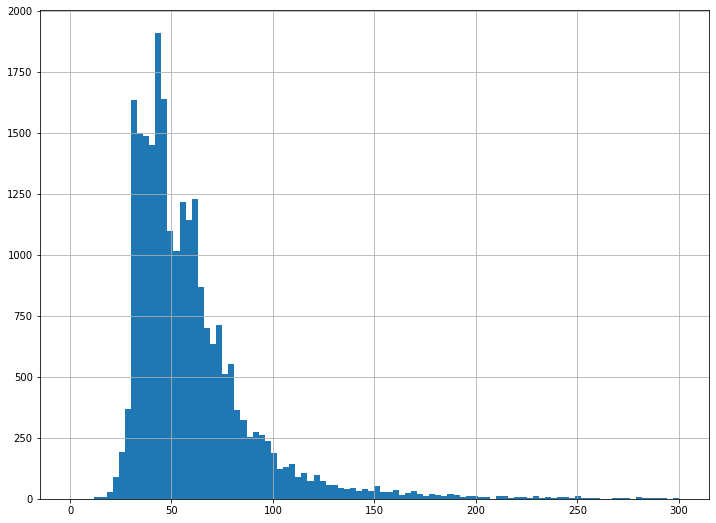

In [28]:
# Построил гистограмму по площади, вывел описание
pd.options.display.float_format ='{:,.2f}'.format
print(estate_data['total_area'].describe())
print(estate_data['total_area'].hist(bins=100, range=(0, 300), figsize=(12,9)))

count      23,650.00
mean       99,431.80
std        50,337.94
min           111.00
25%        76,614.25
50%        95,000.00
75%       114,274.00
max     1,907,500.00
Name: price_per_square_meter, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


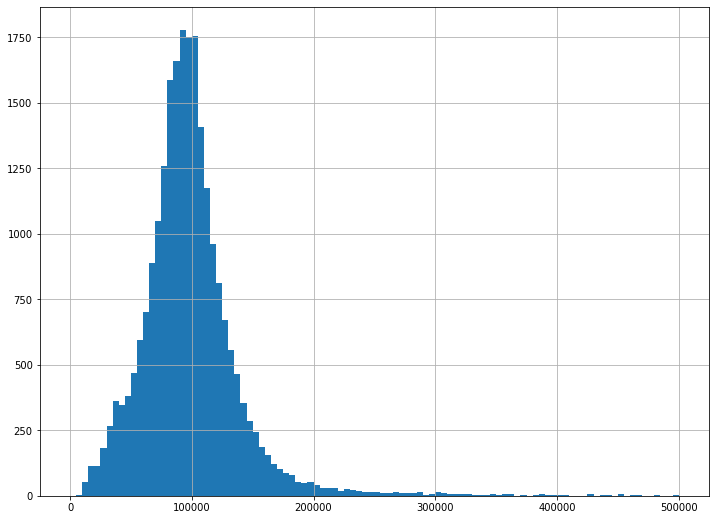

In [29]:
# Построил гистограмму по цене за квадратный метр, вывел описание
print(estate_data['price_per_square_meter'].describe())
print(estate_data['price_per_square_meter'].hist(bins=100, range=(0, 500000), figsize=(12,9)))

count   23,650.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


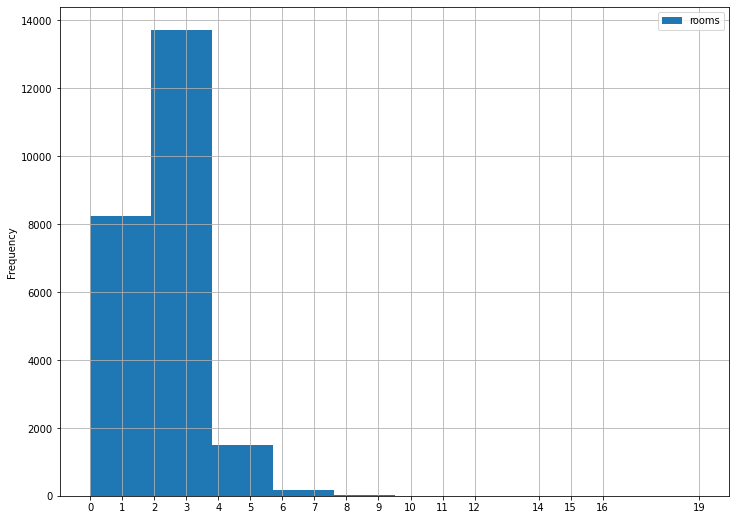

In [30]:
# Построил гистограмму по числу комнат, вывел описание
print(estate_data['rooms'].describe())
print(estate_data.plot(kind='hist', y='rooms', bins=10, figsize=(12,9), grid=True, xticks=estate_data['rooms'].unique()))

count   23,650.00
mean         2.72
std          0.99
min          1.00
25%          2.60
50%          2.65
75%          2.70
max        100.00
Name: ceiling_height, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


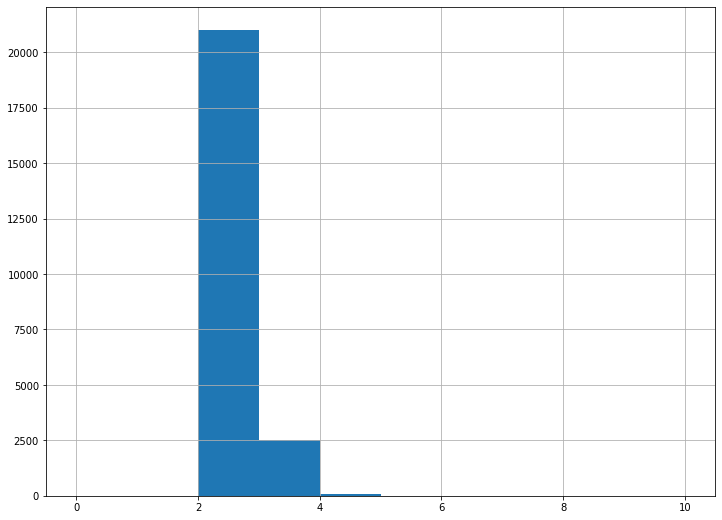

In [31]:
# Построил гистограмму по высоте потолков, вывел описание
print(estate_data['ceiling_height'].describe())
print(estate_data['ceiling_height'].hist(bins=10, range=(0, 10),figsize=(12,9)))

count   20,470.00
mean       180.75
std        219.78
min          1.00
25%         45.00
50%         95.00
75%        231.00
max      1,580.00
Name: days_exposition, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


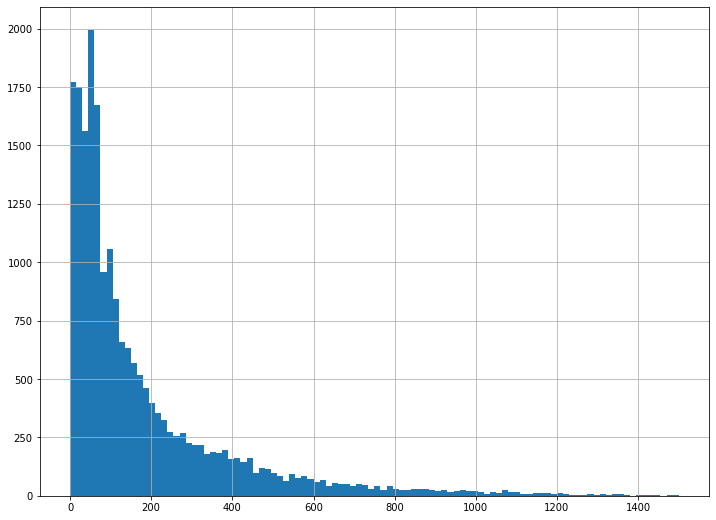

In [32]:
# Вывел описание (среднее - mean и медиану - 50%)
print(estate_data['days_exposition'].describe())
print(estate_data['days_exposition'].hist(bins=100, range=(0, 1500),figsize=(12,9)))

count   23,650.00
mean        60.33
std         35.66
min         12.00
25%         40.00
50%         52.00
75%         69.70
max        900.00
Name: total_area, dtype: float64


(0.0, 200.0)

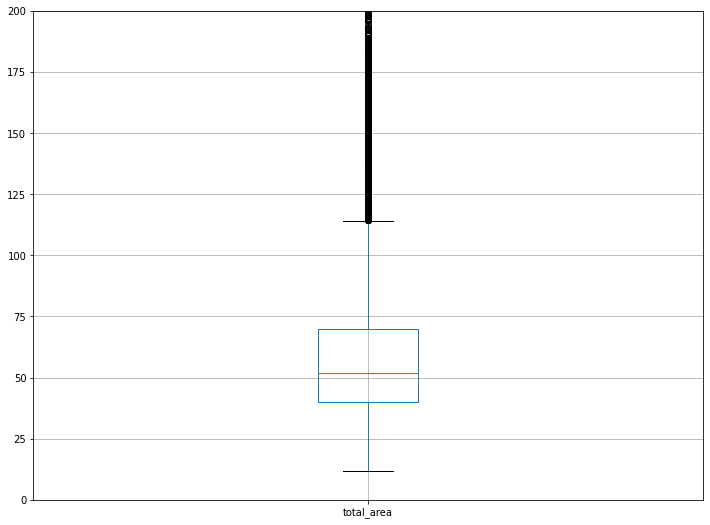

In [33]:
# Построил диаграмму размаха по общей площади
print(estate_data['total_area'].describe()) 
estate_data.boxplot('total_area', figsize=(12,9))
plt.ylim(0, 200)

count      23,650.00
mean       99,431.80
std        50,337.94
min           111.00
25%        76,614.25
50%        95,000.00
75%       114,274.00
max     1,907,500.00
Name: price_per_square_meter, dtype: float64


(0.0, 250000.0)

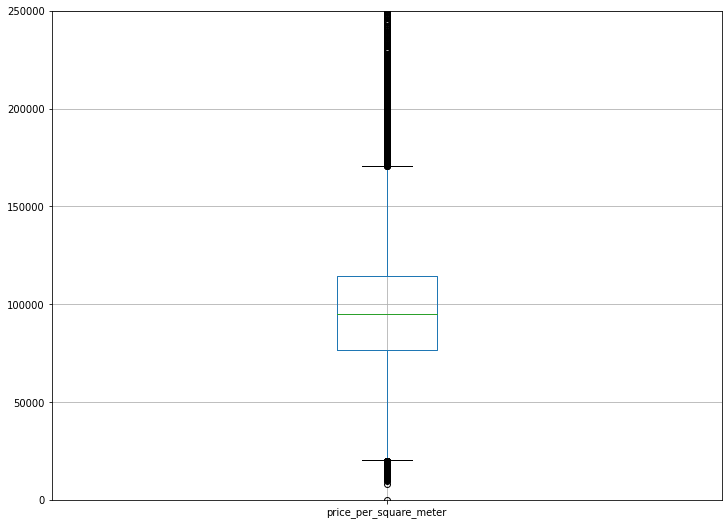

In [34]:
# Построил диаграмму размаха по цене за квадратный метр
print(estate_data['price_per_square_meter'].describe()) 
estate_data.boxplot('price_per_square_meter', figsize=(12,9))
plt.ylim(0, 250000)

count   23,650.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64


(0.0, 15.0)

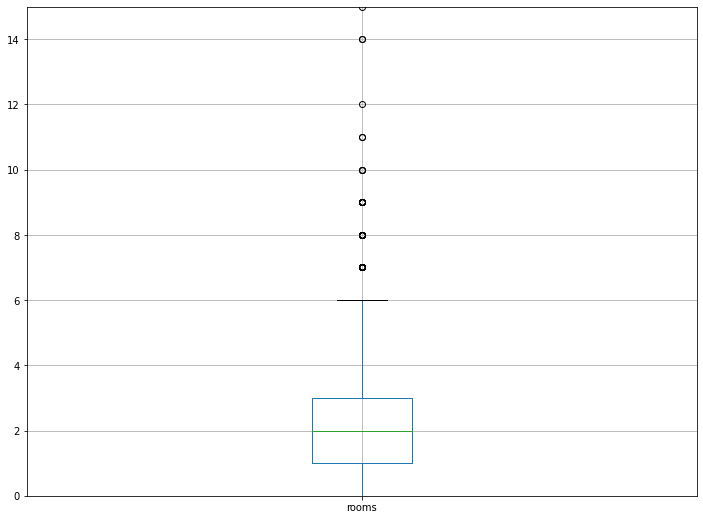

In [35]:
# Построил диаграмму размаха по количеству комнат
print(estate_data['rooms'].describe()) 
estate_data.boxplot('rooms', figsize=(12,9))
plt.ylim(0, 15)

count   23,650.00
mean         2.72
std          0.99
min          1.00
25%          2.60
50%          2.65
75%          2.70
max        100.00
Name: ceiling_height, dtype: float64


(0.0, 5.0)

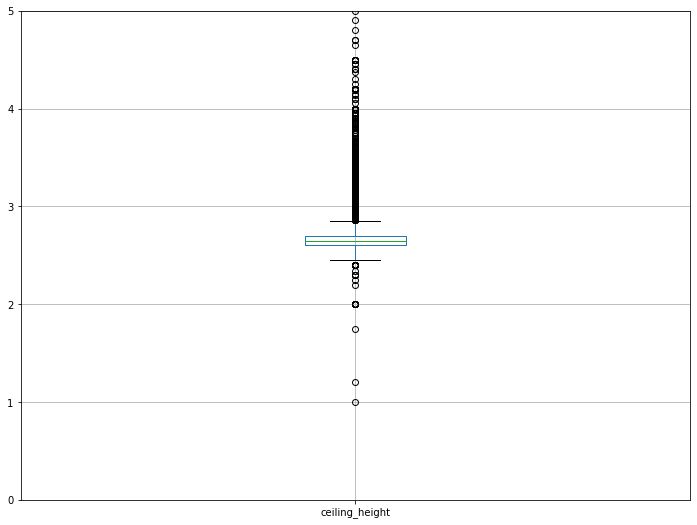

In [36]:
# Построил диаграмму размаха по высоте потолков
print(estate_data['ceiling_height'].describe()) 
estate_data.boxplot('ceiling_height', figsize=(12,9))
plt.ylim(0, 5)

count   20,470.00
mean       180.75
std        219.78
min          1.00
25%         45.00
50%         95.00
75%        231.00
max      1,580.00
Name: days_exposition, dtype: float64


(0.0, 600.0)

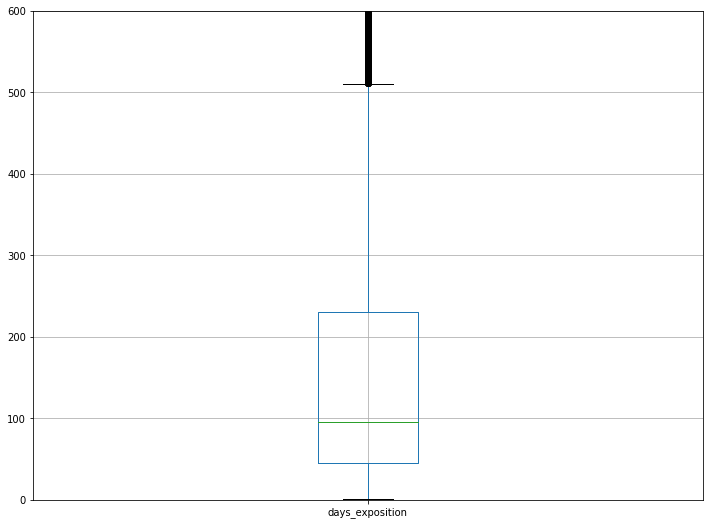

In [37]:
# Построил диаграмму размаха по времени продажи квартиры
print(estate_data['days_exposition'].describe()) 
estate_data.boxplot('days_exposition', figsize=(12,9))
plt.ylim(0, 600)

In [38]:
# Сделал чистую базу без выбросов
good_estate_data = estate_data.query('total_area <= 114 and \
    20000 <= price_per_square_meter <= 170000 and rooms <= 6 and \
    2.4 <= ceiling_height <= 4 and days_exposition <= 510')
display(good_estate_data.head())
good_estate_data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_per_square_meter,datetime,weekday,weekday_name,month,month_name,year,floor_category,ratio_living_total,ratio_kitchen_total
1,7,3350000,40.40,2018-12-04T00:00:00,1,2.65,11,18.60,1,False,False,False,11.00,2,посёлок Шушары,12817,18603,0,3500,0,3500,81.00,82920,2018-12-04,1,вторник,12,декабрь,2018,первый,0.46,0.27
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856,8098,2,112,1,48,121.00,100000,2018-06-19,1,вторник,6,июнь,2018,другой,0.32,0.41
5,10,2890000,30.40,2018-09-10T00:00:00,1,2.65,12,14.40,5,False,False,False,9.10,0,городской посёлок Янино-1,26756,13105,0,3500,0,3500,55.00,95065,2018-09-10,0,понедельник,9,сентябрь,2018,другой,0.47,0.30
6,6,3700000,37.30,2017-11-02T00:00:00,1,2.65,26,10.60,6,False,False,False,14.40,1,посёлок Парголово,52996,19143,0,3500,0,3500,155.00,99195,2017-11-02,3,четверг,11,ноябрь,2017,другой,0.28,0.39
8,20,2900000,33.16,2018-05-23T00:00:00,1,2.65,27,15.43,26,False,False,False,8.81,0,посёлок Мурино,26756,13105,0,3500,0,3500,189.00,87454,2018-05-23,2,среда,5,май,2018,другой,0.47,0.27


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17458 entries, 1 to 23646
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            17458 non-null  int64         
 1   last_price              17458 non-null  int64         
 2   total_area              17458 non-null  float64       
 3   first_day_exposition    17458 non-null  object        
 4   rooms                   17458 non-null  int64         
 5   ceiling_height          17458 non-null  float64       
 6   floors_total            17458 non-null  int64         
 7   living_area             17458 non-null  float64       
 8   floor                   17458 non-null  int64         
 9   is_apartment            17458 non-null  bool          
 10  studio                  17458 non-null  bool          
 11  open_plan               17458 non-null  bool          
 12  kitchen_area            17458 non-null  float6

In [39]:
# Описание
good_estate_data[['last_price', 'total_area','rooms', 'ceiling_height' ]].describe().loc[['min', 'max']]

,last_price,total_area,rooms,ceiling_height
min,"600,000.00",13.00,0.00,2.40
max,"18,500,000.00",114.00,6.00,4.00


0.015544194910689965


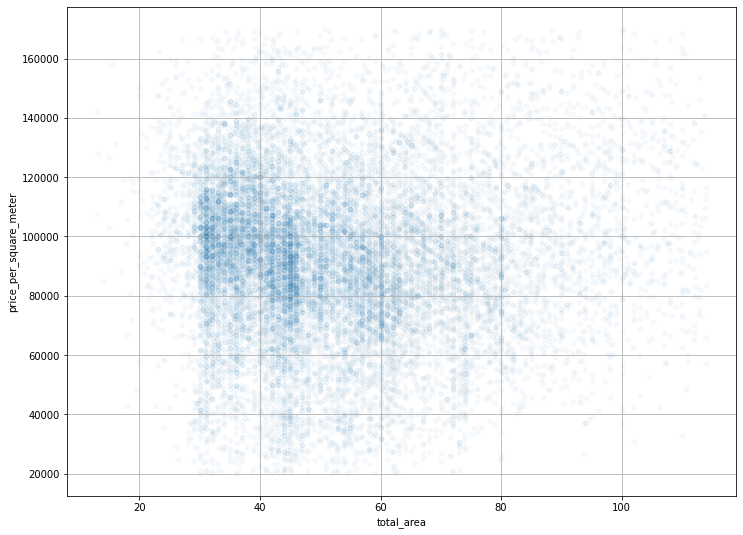

In [40]:
# Построил график зависимости цены от площади
(
good_estate_data
    #.pivot_table(index='total_area', values='price_per_square_meter', aggfunc='median')
    .plot(x='total_area', y='price_per_square_meter', kind='scatter', grid=True, figsize=(12, 9), alpha=0.03)
)
print(good_estate_data['total_area'].corr(good_estate_data['price_per_square_meter']))

-0.17104107164129814


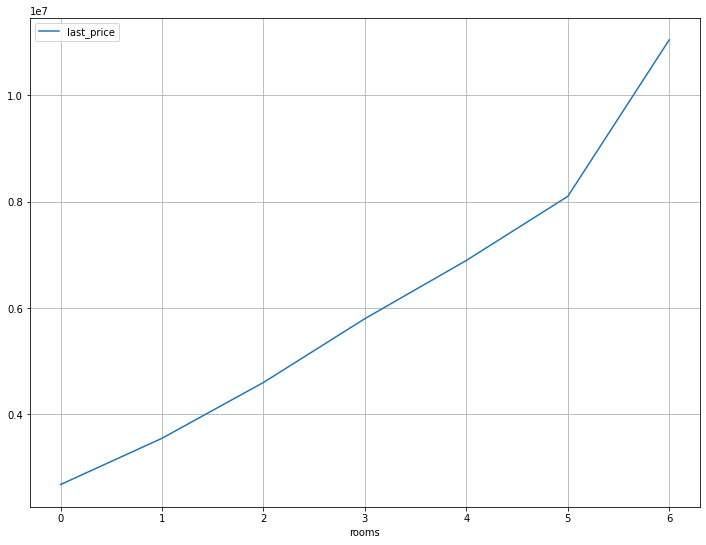

In [41]:
# Построил график зависимости цены от числа комнат
(
good_estate_data
    .pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 9))
)
print(good_estate_data['rooms'].corr(good_estate_data['price_per_square_meter']))

-0.22016865453007464


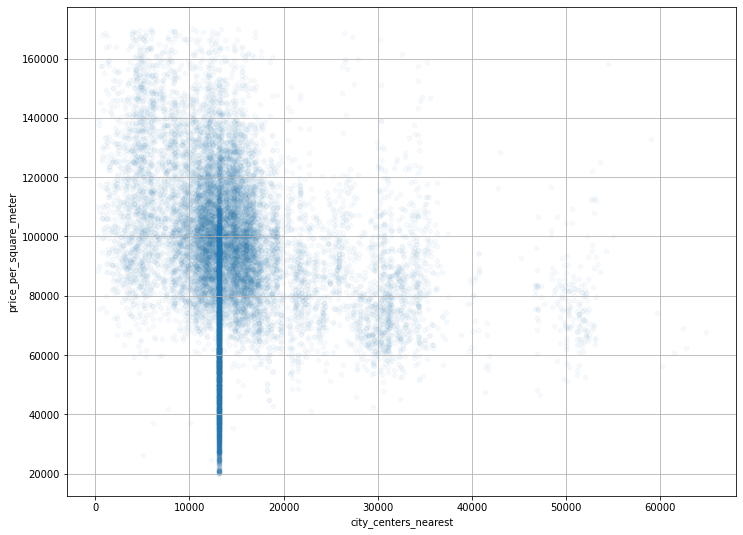

In [43]:
# Построил график зависимости цены от удалённости от центра
(
good_estate_data
    #.pivot_table(index='city_centers_nearest', values='price_per_square_meter', aggfunc='median')
    .plot(x='city_centers_nearest', y='price_per_square_meter', kind='scatter', grid=True, figsize=(12, 9), alpha=0.03)
)
print(good_estate_data['city_centers_nearest'].corr(good_estate_data['price_per_square_meter']))

(0.0, 200000.0)

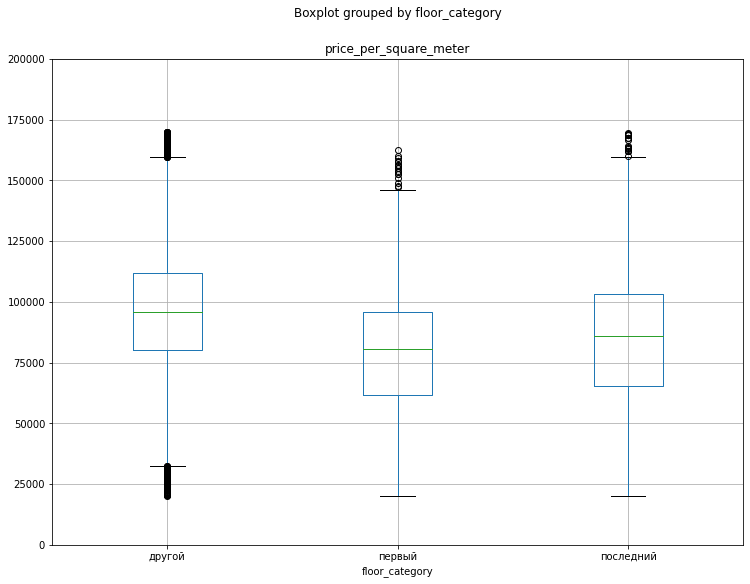

In [44]:
# Построил график зависимости цены от расположения квартиры
good_estate_data.boxplot(column = 'price_per_square_meter', by = 'floor_category', figsize=(12,9))
plt.ylim(0, 200000)

(0.0, 250000.0)

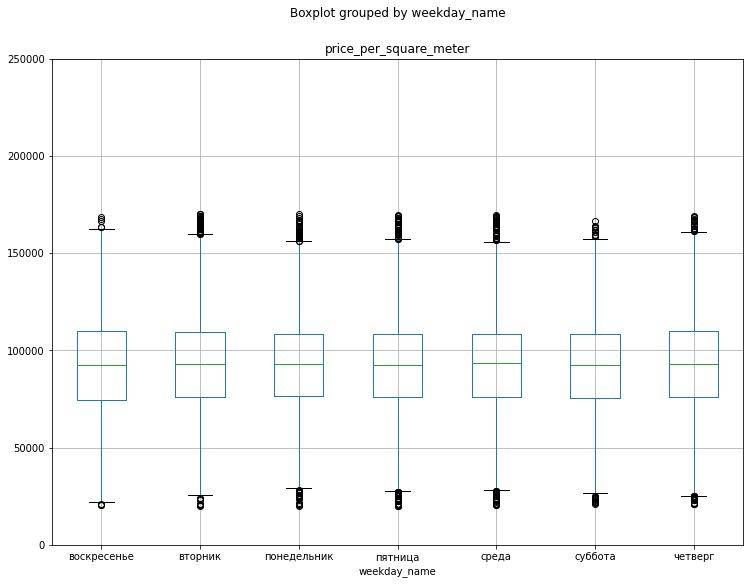

In [45]:
# Построил график зависимости цены от дня недели
good_estate_data.boxplot(column = 'price_per_square_meter', by = 'weekday_name', figsize=(12,9))
plt.ylim(0, 250000)

(0.0, 250000.0)

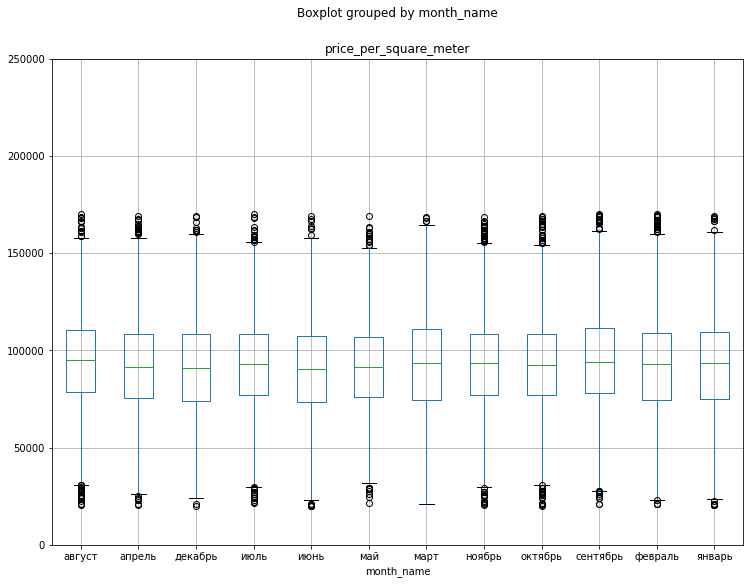

In [46]:
# Построил график зависимости цены от месяца размещения
good_estate_data.boxplot(column = 'price_per_square_meter', by = 'month_name', figsize=(12,9))
plt.ylim(0, 250000)

(0.0, 250000.0)

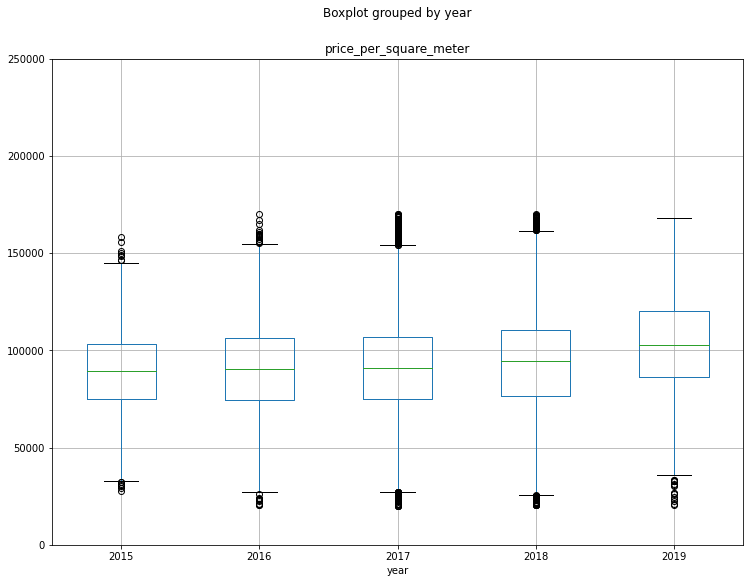

In [47]:
# Построил график зависимости цены от года размещения
good_estate_data.boxplot(column = 'price_per_square_meter', by = 'year', figsize=(12,9))
plt.ylim(0, 250000)

In [48]:
# Выделил 10 населённых пунктов с наибольшим числом объявлений и среднюю цену квадратного метра в них 
top_10 = good_estate_data['locality_name'].value_counts().head(10).index
print(top_10)
(
good_estate_data[good_estate_data['locality_name']
    .isin(top_10)].groupby('locality_name').agg({'price_per_square_meter': 'mean'})
    .sort_values(by='price_per_square_meter', ascending = False)
)

Index(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск',
       'Колпино', 'посёлок Парголово', 'деревня Кудрово', 'Пушкин', 'Гатчина',
       'Выборг'],
      dtype='object')


,price_per_square_meter
locality_name,
Санкт-Петербург,"104,538.44"
Пушкин,"100,624.79"
деревня Кудрово,"92,599.98"
посёлок Парголово,"89,336.52"
посёлок Мурино,"86,019.41"
посёлок Шушары,"77,939.37"
Колпино,"74,680.84"
Гатчина,"68,739.61"
Всеволожск,"66,737.15"


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_per_square_meter,datetime,weekday,weekday_name,month,month_name,year,floor_category,ratio_living_total,ratio_kitchen_total,city_centers_km
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856,8098,2,112,1,48,121.00,100000,2018-06-19,1,вторник,6,июнь,2018,другой,0.32,0.41,8
9,18,5400000,61.00,2017-02-26T00:00:00,3,2.50,9,43.60,7,False,False,False,6.50,2,Санкт-Петербург,50898,15008,0,3500,0,3500,289.00,88524,2017-02-26,6,воскресенье,2,февраль,2017,другой,0.71,0.11,15
10,5,5050000,39.60,2017-11-16T00:00:00,1,2.67,12,20.30,3,False,False,False,8.50,0,Санкт-Петербург,38357,13878,1,310,2,553,137.00,127525,2017-11-16,3,четверг,11,ноябрь,2017,другой,0.51,0.21,14
15,16,4650000,39.00,2017-11-18T00:00:00,1,2.65,14,20.50,5,False,False,False,7.60,1,Санкт-Петербург,12900,14259,1,590,1,296,19.00,119230,2017-11-18,5,суббота,11,ноябрь,2017,другой,0.53,0.19,14
16,11,6700000,82.00,2017-11-23T00:00:00,3,3.05,5,55.60,1,False,False,False,9.00,0,Санкт-Петербург,22108,10698,3,420,0,3500,397.00,81707,2017-11-23,3,четверг,11,ноябрь,2017,первый,0.68,0.11,11


<AxesSubplot:xlabel='city_centers_km'>

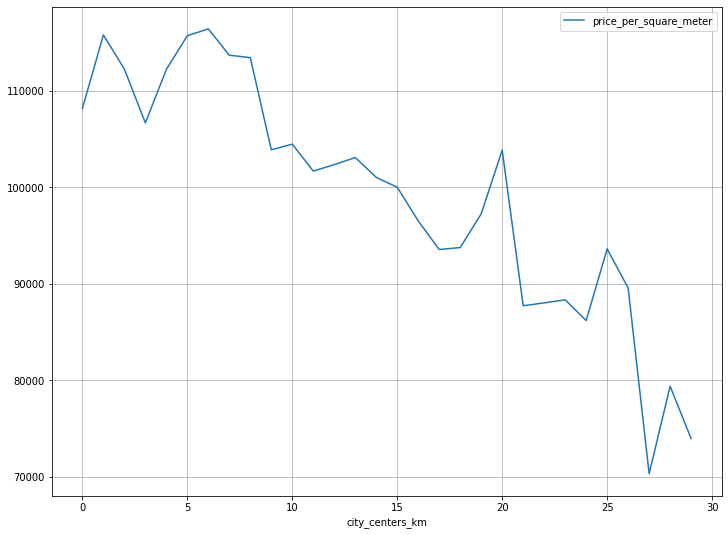

In [49]:
# Выделил Питер
st_peterburg = good_estate_data.query('locality_name == "Санкт-Петербург"')

# Создал столбец с округленным расстоянием до центра в км
st_peterburg['city_centers_km'] = (st_peterburg['city_centers_nearest'] / 1000).round()
st_peterburg['city_centers_km'] = st_peterburg['city_centers_km'].astype('int')
display(st_peterburg.head())

# Построил график зависимости цены от расстояния
(
st_peterburg
    .pivot_table(index='city_centers_km', values='price_per_square_meter', aggfunc='median')
    .plot(grid=True, figsize=(12, 9))
)

-0.17929749323115807


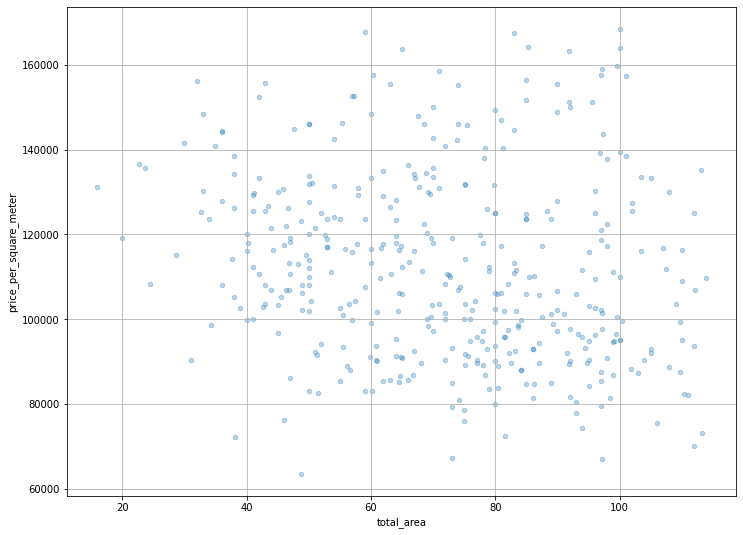

In [50]:
# Построил график зависимости цены от площади для центра Питера
st_peterburg_center = st_peterburg.query('city_centers_km <= 3')
(
st_peterburg_center
    #.pivot_table(index='total_area', values='price_per_square_meter', aggfunc='median')
    .plot(x='total_area', y='price_per_square_meter', kind='scatter', grid=True, figsize=(12, 9), alpha=0.3)
)
print(st_peterburg_center['total_area'].corr(st_peterburg_center['price_per_square_meter']))

-0.17687761709258754


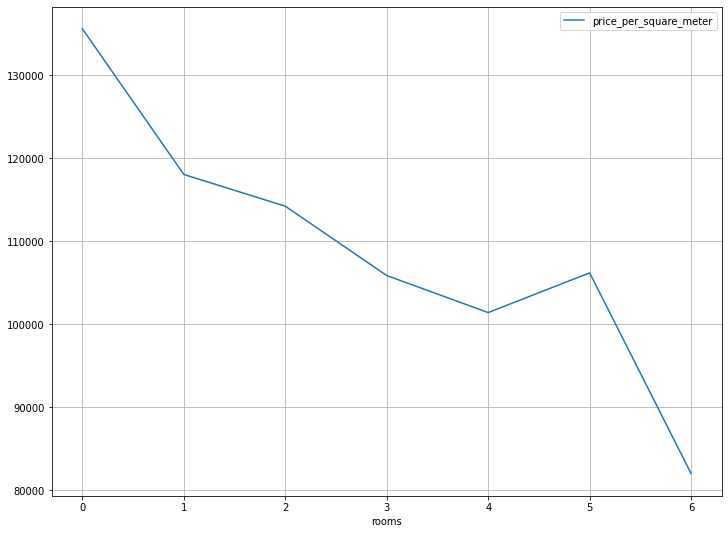

In [51]:
# Построил график зависимости цены от числа комнат для центра Питера
(
st_peterburg_center
    .pivot_table(index='rooms', values='price_per_square_meter', aggfunc='median')
    .plot(grid=True, figsize=(12, 9))
)
print(st_peterburg_center['rooms'].corr(st_peterburg_center['price_per_square_meter']))

-0.1633307045865225


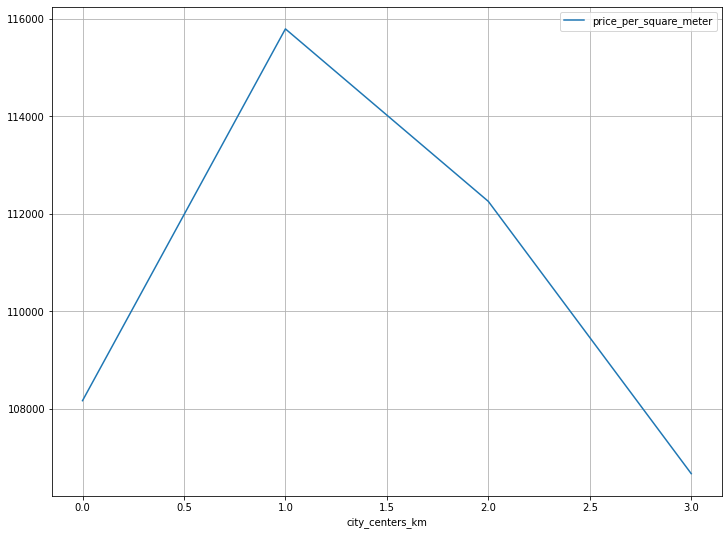

In [52]:
# Построил график зависимости цены от удалённости от центра для центра Питера
(
st_peterburg_center
    .pivot_table(index='city_centers_km', values='price_per_square_meter', aggfunc='median')
    .plot(grid=True, figsize=(12, 9))
)
print(st_peterburg_center['city_centers_km'].corr(st_peterburg_center['price_per_square_meter']))

(0.0, 200000.0)

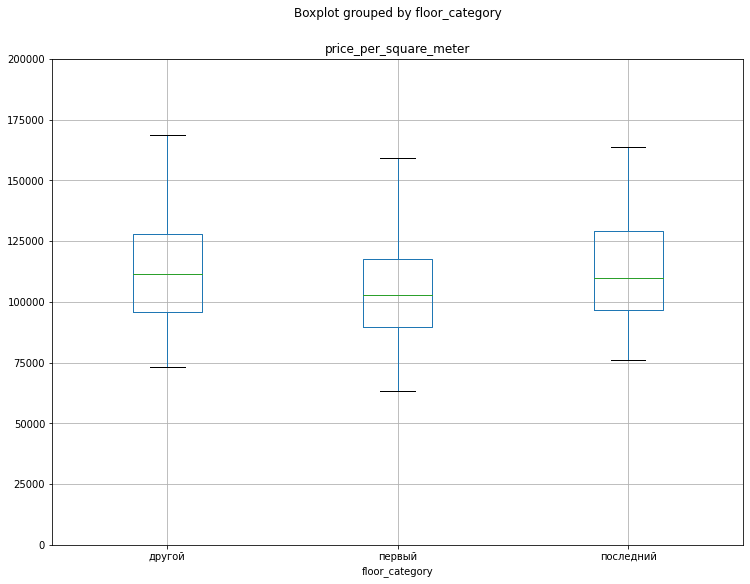

In [53]:
# Построил график зависимости цены от расположения квартиры для центра Питера
st_peterburg_center.boxplot(column = 'price_per_square_meter', by = 'floor_category', figsize=(12,9))
plt.ylim(0, 200000)

(0.0, 250000.0)

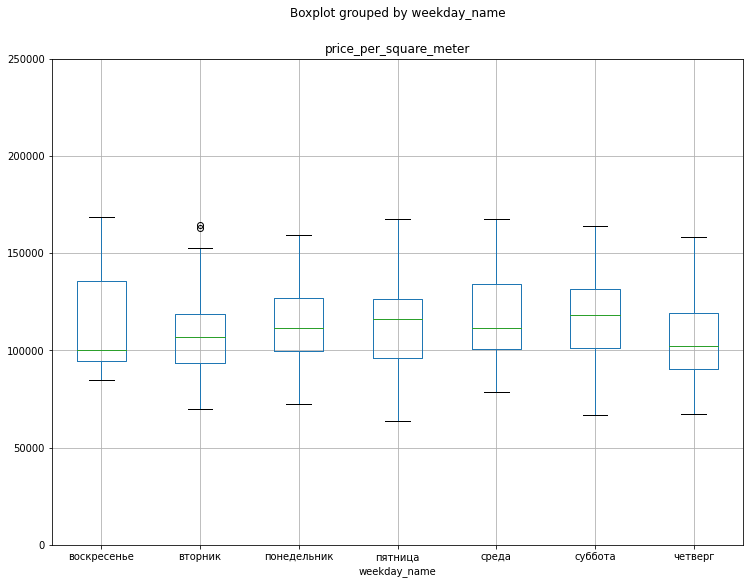

In [54]:
# Построил график зависимости цены от дня недели для центра Питера
st_peterburg_center.boxplot(column = 'price_per_square_meter', by = 'weekday_name', figsize=(12,9))
plt.ylim(0, 250000)

(0.0, 250000.0)

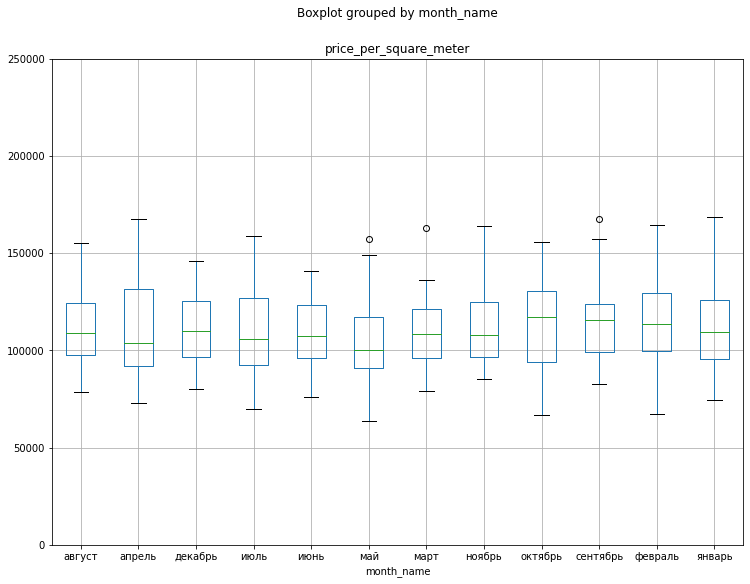

In [55]:
# Построил график зависимости цены от месяца размещения для центра Питера
st_peterburg_center.boxplot(column = 'price_per_square_meter', by = 'month_name', figsize=(12,9))
plt.ylim(0, 250000)

(0.0, 250000.0)

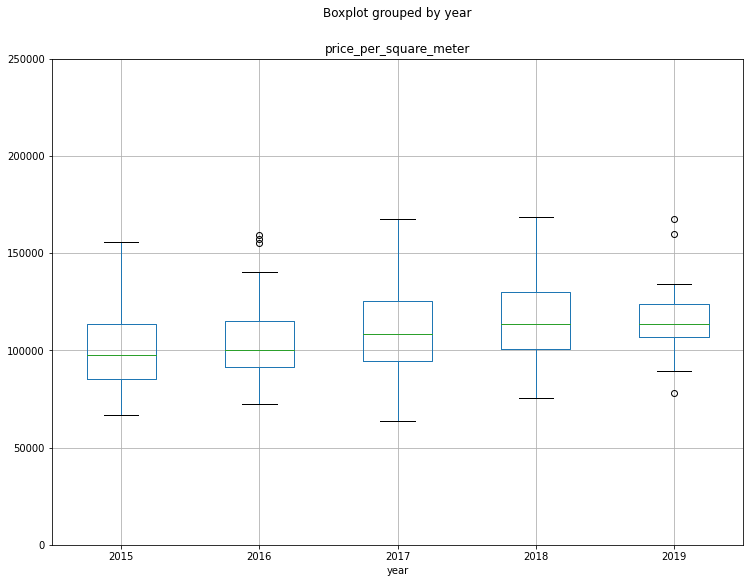

In [56]:
# Построил график зависимости цены от года размещения для центра Питера
st_peterburg_center.boxplot(column = 'price_per_square_meter', by = 'year', figsize=(12,9))
plt.ylim(0, 250000)

**Вывод**

1. Изучил следующие параметры: площадь, цена, число комнат, высота потолков. Для изучения данных параметров построил гистограммы и диаграммы размаха. Из полученной диаграммы по площади установил, что наиболее частые повторяющиеся значения находятся в интервале от 30 до 50 метров квадратных, распределение Пуассона. Для цены самое повторяющееся значение 100000, нормальное распределение. Из диаграммы по количеству комнат установил, что 2 и 3 комнаты фигурируют в таблице чаще всего. Высота потолков от 2 до 3 метров. Также в гистограммах обнаружил странные минимальные и максимальные значения параметров.  

2. Изучил время продажи квартиры. Построил гистограмму, среднее арифметическое равняется 180 дней, медиана 95. В среднем квартиры продаются от 45 до 231 дня. Из гистограммы мы видим, что самые частые продажи осуществляются за 45 и 60 дней. Продажу можно считать очень быстрой, если она прошла меньше, чем за 45 дней, а необычно долго, если дольше 231 дня.     

3. Основываясь на данных из диаграмм размаха, очистил таблицу от выбросов. Сделал срез по таким критериям: для общей площади до 114 метров квадратных; для цены за метр квадратный диапозон от 20000 до 170000; для комнат - до 6 включительно; для высоты потолков от 2.4 до 2.8 метров; для дней размещения объявлений до 510. 

4. На графике зависимости цены от площади корреляции не наблюдается, зависимости нет. На графике зависимости цены от количества комнат, наблюдается обратная корреляция. Чем больше комнат, тем ниже цена. Но из-за увеличения цены от 5 комнат, коэффициент корреляции Пирсона имеет небольшое значение. На графике зависимости цены от удаленности также обратная корреляция. Чем дальше от центра, тем ниже стоимость квадратного метра. Коэффициент корреляции Пирсона невысокий. График цены от расположения квартиры по этажам подтверждает зависимость. Квартиры находящиеся на первом этаже стоят дешевле всего, дальше идут квартиры на последнем этаже. Самые дорогие квартиры относятся к категории "другой". На графиках зависимости от даты размещения, по дням и месяцам зависимости не наблюдается, цена остается примерно на одном уровне. На графике по году размещения зависимость есть, цены за квадратный метр вырастают от года к году.  

5. Основываясь на данных полученных из таблицы top_10, можно сделать выводы, что самая высокая цена за квадратный метр в Санкт-Петербурге, самая низкая стоимость в Выборге.

6. Для Питера корреляция цен от площади наблюдается, в отличие от общего графика. В графике для Санкт-Петербурга прослеживается уменьшение цены за квадратный метр при увеличении метража квартиры. Зависимость цены от количества комнат для Питера наблюдается также, как и в общем графике, корреляция даже выше. На графике цены от удаленности для Санкт-Петербурга зависимости не наблюдается, так как выбран небольшой центральный диапозон. График цены от расположения квартиры по этажам для Питера показывает тоже самое, что и общий график. На графиках зависимости от даты размещения для Питера, по дням зависимости также не наблюдается. По месяцам стоимость в основном одиннаковая, за исключением марта и августа, там цены немного повысились. По году совпадает с результатами общего графика, цены также растут из года в год. В целом цена за квадратный метр в среднем выше, чем на общих графиках. Отличными параметрами Санкт-Петербурга от общей базы являются цена от площади и удаленности от центра. По остальным параметрам результаты схожи с общим.            

## 5. Общий вывод 

По данным сервиса Яндекс.Недвижимость о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет, можно сделать несколько выводов:

1. Чаще всего квартира продается за 45 и 60 дней, т.е. за полтора - два месяца. Если удалось продать квартиру меньше чем за полтора месяца, то эту продажу можно считать очень быстрой. Очень долгой можно считать продажу дольше, чем 7 с половиной месяцев. 

2. Ключевые параметры для общей базы, которые влияют на стоимость квартиры: число комнат, удаленность от центра, расположение квартиры, также можно сделать вывод, что цены растут из года в год. Результаты исследования показывают, что чем больше комнат, тем ниже цена за квадратный метр, такая же ситуация с расстоянием до центра города, чем дальше от центра, тем ниже стоимость. Квартиры, располагающиеся не на первом и последнем этажах, стоят дороже. Остальные параметры не имеют зависимости от цены. 

3. Параметры, влияющие на стоимость квадратного метра в Санкт-Петербурге, отличаются от общих, хоть и несильно. Площадь, число комнат, расположение квартиры, цены также растут из года в год. В отличие от общей базы для Питера параметр общей площади имеет значение. Чем больше площадь квартиры, тем меньше стоимость квадратного метра. Параметры: количество комнат и расположение квартиры по этажам схожи с общими. Также следует отметить, что в графике зависимости цены от месяца размещения объявления наблюдалось увеличение стоимости в августе и марте. В Санкт-Петербурге самая высокая стоимость квадратного метра.            